In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [45]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [46]:
from functions.stock import download_stock_data
from const.interval import Interval

stock_data = download_stock_data("BBAS3.SA", Interval.DAY.value, 365)

[*********************100%***********************]  1 of 1 completed


In [85]:
dataset = pd.DataFrame({'Close': stock_data['Adj Close'].values}, index=range(len(stock_data)))
display(dataset)

,Close
0,33.039856
1,32.827591
2,32.901428
3,32.864513
4,34.793373
...,...
243,54.230000
244,54.880001
245,55.349998
246,54.520000


In [86]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [87]:
# divide train and test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

166 82


In [88]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [89]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [90]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [91]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
164/164 - 2s - loss: 0.1025 - 2s/epoch - 14ms/step
Epoch 2/100
164/164 - 0s - loss: 0.0267 - 310ms/epoch - 2ms/step
Epoch 3/100
164/164 - 0s - loss: 0.0186 - 325ms/epoch - 2ms/step
Epoch 4/100
164/164 - 0s - loss: 0.0141 - 331ms/epoch - 2ms/step
Epoch 5/100
164/164 - 0s - loss: 0.0100 - 307ms/epoch - 2ms/step
Epoch 6/100
164/164 - 0s - loss: 0.0065 - 309ms/epoch - 2ms/step
Epoch 7/100
164/164 - 0s - loss: 0.0038 - 304ms/epoch - 2ms/step
Epoch 8/100
164/164 - 0s - loss: 0.0022 - 310ms/epoch - 2ms/step
Epoch 9/100
164/164 - 0s - loss: 0.0014 - 301ms/epoch - 2ms/step
Epoch 10/100
164/164 - 0s - loss: 0.0010 - 331ms/epoch - 2ms/step
Epoch 11/100
164/164 - 1s - loss: 9.0978e-04 - 796ms/epoch - 5ms/step
Epoch 12/100
164/164 - 1s - loss: 8.4433e-04 - 605ms/epoch - 4ms/step
Epoch 13/100
164/164 - 0s - loss: 8.8469e-04 - 420ms/epoch - 3ms/step
Epoch 14/100
164/164 - 0s - loss: 8.5870e-04 - 298ms/epoch - 2ms/step
Epoch 15/100
164/164 - 0s - loss: 8.5466e-04 - 297ms/epoch - 2ms/step
E

In [92]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

3/3 [==============================] - 0s 3ms/step
Train Score: 0.64 RMSE
Test Score: 0.79 RMSE


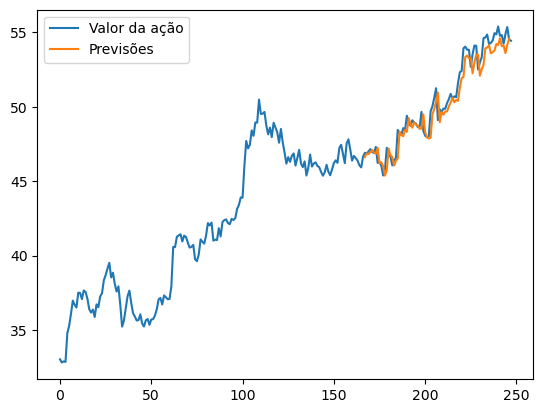

In [93]:
# previsões de train de mudança para plot
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# previsões de test de mudança para plot
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
#plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Valor da ação','Previsões'], fontsize=10)
plt.show()

In [94]:
arr1 = np.array(scaler.inverse_transform(dataset))
arr2 = np.array(testPredictPlot)
valid_indices = ~np.isnan(arr2)

In [95]:
from functions.validation import performance_evaluation
test_performance = performance_evaluation(arr1[valid_indices], arr2[valid_indices])

print("\nPerformance no Conjunto de Teste:")
for metric, value in test_performance.items():
    print(f'{metric}: {value}')


Performance no Conjunto de Teste:
Mean Squared Error (MSE): 0.616512906466052
Median Absolute Deviation (MAD): 0.5085601806640625
Mean Absolute Error (MAE): 0.6002914905548109
R-squared (R²): 0.9329023616942055


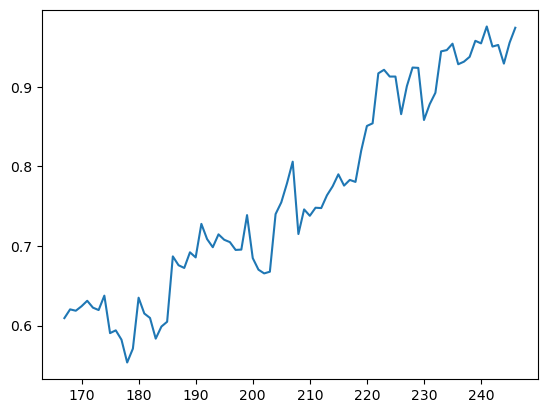

In [84]:
plt.plot(testPredictPlot)